In [1]:
%load_ext autoreload
%autoreload 2

# Deep Gaussian Markov Random Fields on graph (the Graph DGMRF model)

Original code can be found [here](https://github.com/joeloskarsson/graph-dgmrf/blob/main/utils.py). And the article is [here](https://proceedings.mlr.press/v162/oskarsson22a/oskarsson22a.pdf).

In [2]:
# import os
# os.environ["CUDA_VISIBLE_DEVICES"]=""

from functools import partial
from torch.distributions import MultivariateNormal
import torch
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import optax
from jax_tqdm import scan_tqdm
import copy
import equinox as eqx
import numpy as np


key = jax.random.PRNGKey(0)

In [3]:
try:
    gpu_device = jax.devices('gpu')[0]
    cpu_device = jax.devices('cpu')[0]
    print(cpu_device, gpu_device)
except:
    cpu_device = jax.devices('cpu')[0]
    print(cpu_device)

TFRT_CPU_0 cuda:0


## First create some observations
We sample a GMRF with Cholesky sampling

In [4]:
H = 50
W = 50
r = 5

In [5]:
from dgmrf.utils import cholesky_sampling_gaussian_field
key, subkey = jax.random.split(key)
source_term = jax.random.normal(subkey, shape=(H * W,))

with jax.default_device(cpu_device):
    x_ori = cholesky_sampling_gaussian_field(r, source_term.flatten(), H, W)

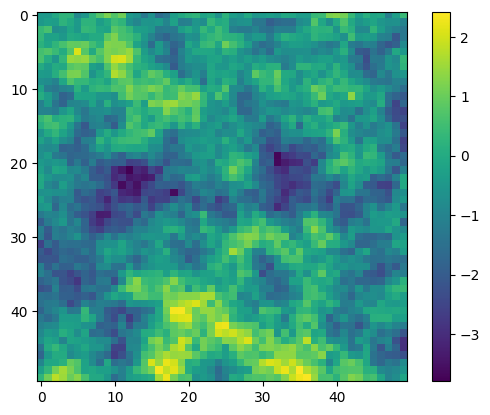

In [6]:
plt.imshow(x_ori)
plt.colorbar()
plt.show()

Add noise over the observations

In [7]:
key, subkey = jax.random.split(key)
true_sigma_noise = 0.4
y = x_ori + jax.random.normal(subkey, x_ori.shape) * true_sigma_noise
N = H * W

In [8]:
mask = jnp.zeros_like(y)

mask = mask.at[5:25, 20:25].set(1)

y = jnp.where(mask == 0, y, 0)

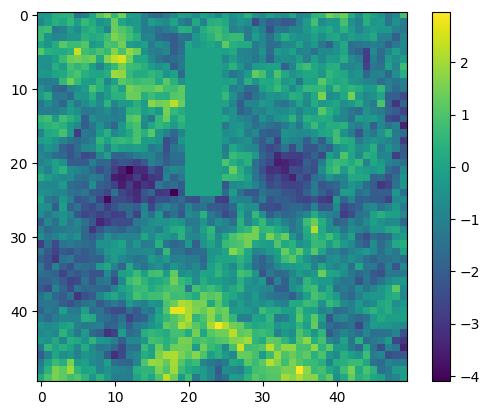

In [9]:
plt.imshow(y)
plt.colorbar()
plt.show()

## Define the DGMRF components

In [10]:
from dgmrf.models import DGMRF, MeanField, FactorizedS
from dgmrf.utils import get_adjacency_matrix_lattice

**Note:** It seems that, when $L > 2$ the variational distribution means are badly estimated. This causes problems for the initialization of the CG algorithm for posterior mean. Moreover the posterior mean from exact computation also suffers from a too strong smoothing effect. More fine-tuning in the optimization process seems required.

In [11]:
L = 2
Nq = 10

In [12]:
y = y.flatten()
mask = mask.flatten()

In [13]:
key, subkey = jax.random.split(key, 2)

dgmrf = DGMRF(
    subkey,
    L,
    A_D=(get_adjacency_matrix_lattice(H, W), 4 * jnp.ones(H * W)),
    log_det_method="eigenvalues",
    with_bias=True,
    non_linear=False
)

Instanciate the variational distribution we can choose between **Mean-Field** variational distribution and the **factorized distribution** proposed by Oskarsson. While the latter gives slightly better results it is much slower.

In [14]:
key, subkey1, subkey2 = jax.random.split(key, 3)

q_phi = MeanField(N=H * W, key=subkey)
# q_phi = FactorizedS(
#     N=H * W,
#     dgmrf_args=(subkey1, 1),
#     dgmrf_kwargs= {
#         "A_D":(get_adjacency_matrix_lattice(H, W), 4 * jnp.ones(H * W)),
#         "log_det_method":"eigenvalues"
#     },
#     key=subkey2
# )

Define the Model equinox module `(DGMRF, VariationalDistribution, noise_parameter_array)`. This is just a container-like structure

In [ ]:
from dgmrf.train import Model
model = Model(dgmrf, q_phi, jnp.log(true_sigma_noise))

## Variational inference to compute model parameters

In [16]:
n_iter = 1000
lr_graph = 1e-2

lr = lr_graph
tx = optax.multi_transform(
    {
     'dgmrf': optax.adam(lr), 'log_sigma': optax.adam(0), 'q_phi': optax.adam(lr)},
    Model(dgmrf="dgmrf", posterior="q_phi", noise_parameter="log_sigma")
)
opt_state = tx.init(eqx.filter(model, eqx.is_array))

In [17]:
from dgmrf.losses import dgmrf_elbo
from dgmrf.train import train_loop

key, subkey = jax.random.split(key, 2)
model, loss_val, opt_state= train_loop(dgmrf_elbo, y, n_iter, params_init, static, tx, opt_state, subkey, N, Nq, mask=mask)

  0%|          | 0/1000 [00:00<?, ?it/s]

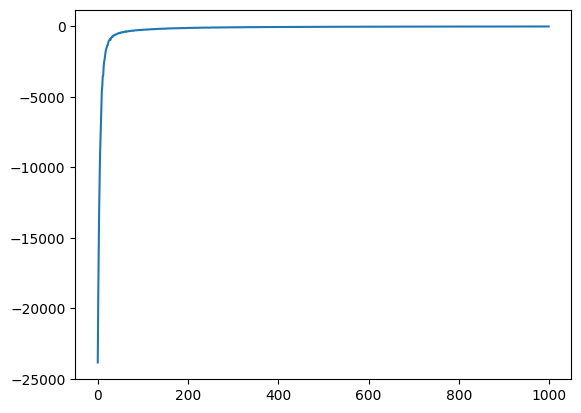

In [18]:
plt.plot(loss_val)
plt.show()

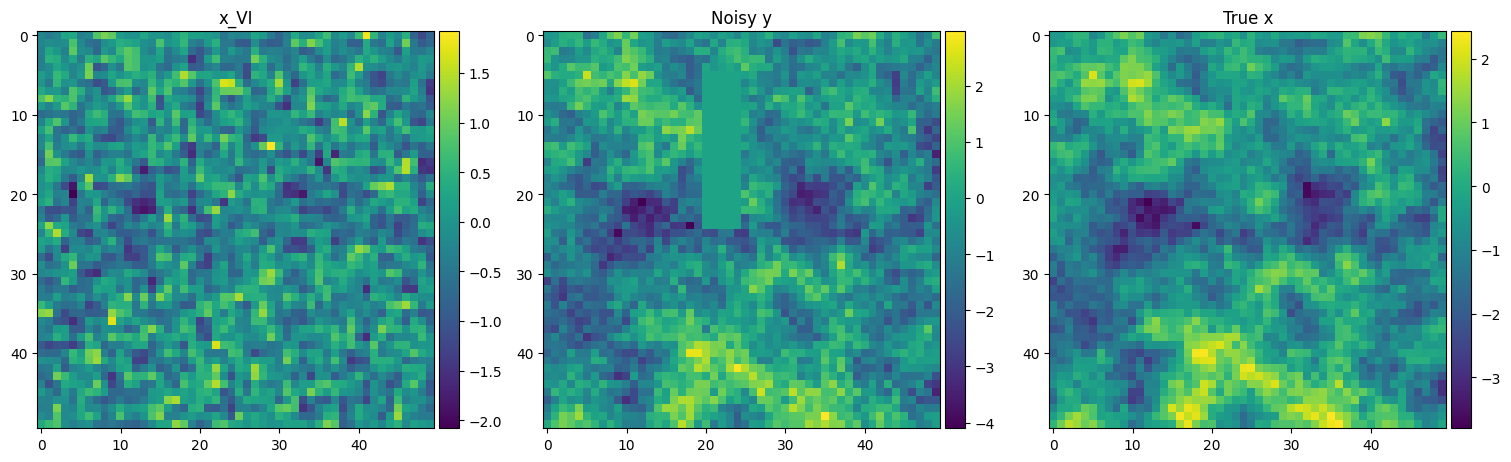

In [19]:
fig, axes = plt.subplots(1, 3)
fig.set_size_inches(18.5, 10.5)

im = axes[0].imshow(model.posterior.params["nu"].reshape(H, W))
axes[0].set_title("x_VI")
divider = make_axes_locatable(axes[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im = axes[1].imshow(y.reshape(H, W))
axes[1].set_title("Noisy y")
divider = make_axes_locatable(axes[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im = axes[2].imshow(x_ori)
axes[2].set_title("True x")
divider = make_axes_locatable(axes[2])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

plt.show()

## Analyze the parameters that have been learned

We have: $\alpha$, $\beta$, $\gamma$, $b$, $s$ (slope for leakyReLU, not used if nonlinear=False)

In [20]:
from dgmrf.layers import GraphLayer
for l in range(L):
    print(f"Params for layer {l=}", GraphLayer.params_transform(model.dgmrf.layers[l].params))

Params for layer l=0 [ 0.6827721  -0.47252312  0.7476615   0.25539374  0.82897526]
Params for layer l=1 [ 0.6617154  -0.3903938   0.6238961  -0.11402237  0.6377603 ]


## Posterior mean computation with conjugate gradient

[]

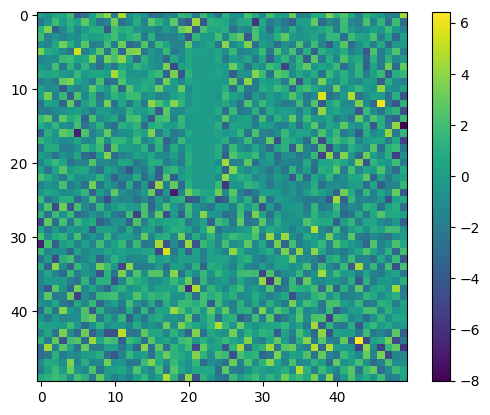

In [22]:
z = model.dgmrf(y)
plt.imshow(z.reshape((H, W)))
plt.colorbar()
plt.plot()

**Note**, on this example, we can still afford the computation of exactly inverting $\tilde{Q}$ to compute exactly the posterior mean without the conjugate gradient:

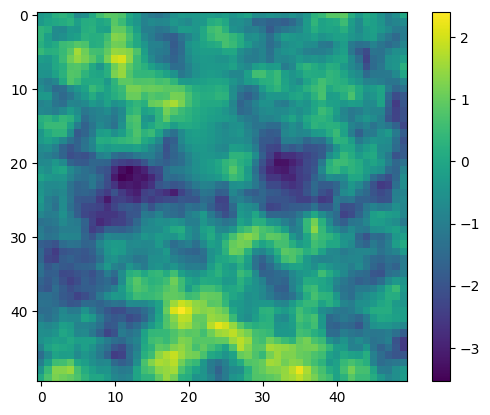

In [23]:
mu_post_exact = model.dgmrf.get_post_mu(
    y,
    model.noise_parameter,
    mask=mask,
    method="exact"
)
plt.imshow(mu_post_exact.reshape((H, W)))
plt.colorbar()
plt.show()

But we can always compute the posterior mean with approximate inversion of $\tilde{Q}$ using conjugate gradient

In [24]:
xpost_mean = model.dgmrf.get_post_mu(y, model.noise_parameter, model.posterior.params["nu"], mask=mask, method="cg")

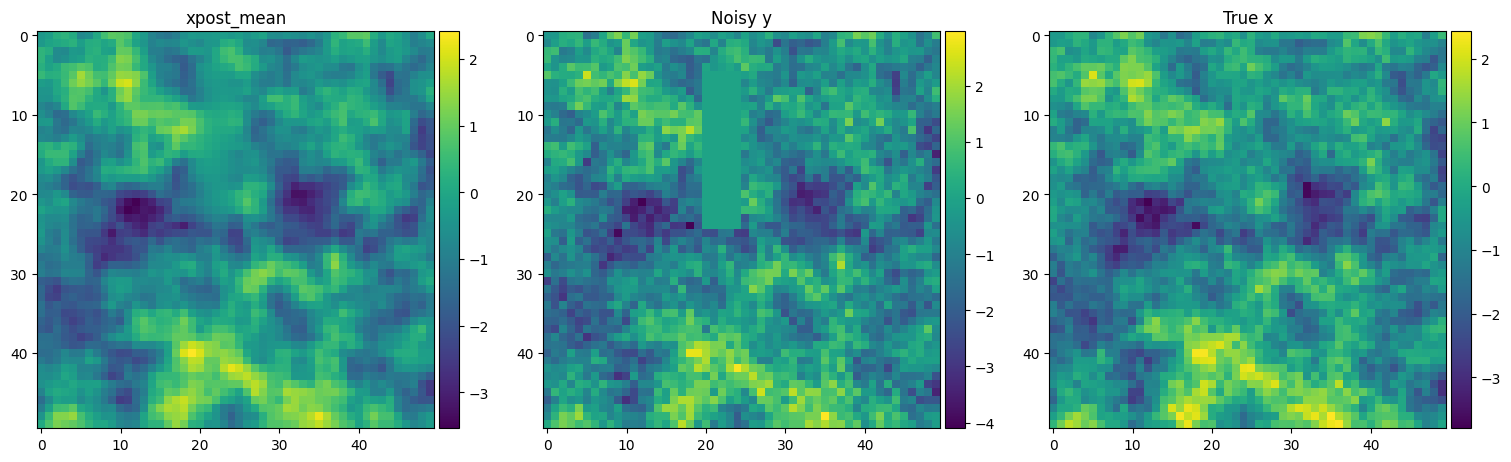

In [25]:
fig, axes = plt.subplots(1, 3)
fig.set_size_inches(18.5, 10.5)

im = axes[0].imshow(xpost_mean.reshape(H, W))
axes[0].set_title("xpost_mean")
divider = make_axes_locatable(axes[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im = axes[1].imshow(y.reshape(H, W))
axes[1].set_title("Noisy y")
divider = make_axes_locatable(axes[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im = axes[2].imshow(x_ori)
axes[2].set_title("True x")
divider = make_axes_locatable(axes[2])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

plt.show()

## Posterior samples to compute the posterior marginal variances

In [26]:
nb_samples = 50

key, subkey = jax.random.split(key, 2)
x_post_samples = model.dgmrf.posterior_samples(nb_samples, y, model.noise_parameter, subkey, x0=xpost_mean, mask=mask)

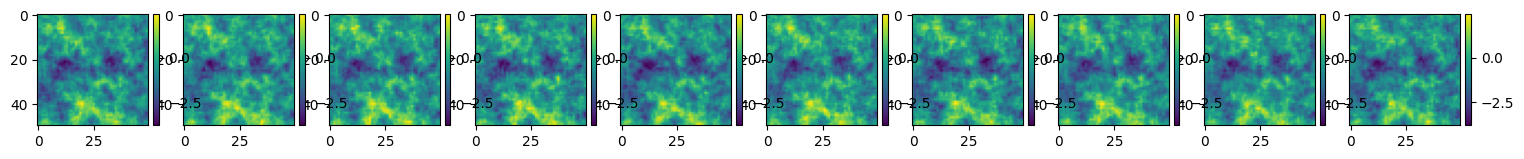

In [27]:
fig, axes = plt.subplots(1, 10)
fig.set_size_inches(18.5, 10.5)

for i, ax in enumerate(axes):
    ax.imshow(x_post_samples[i].reshape(H, W))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')

### Simple MC estimator

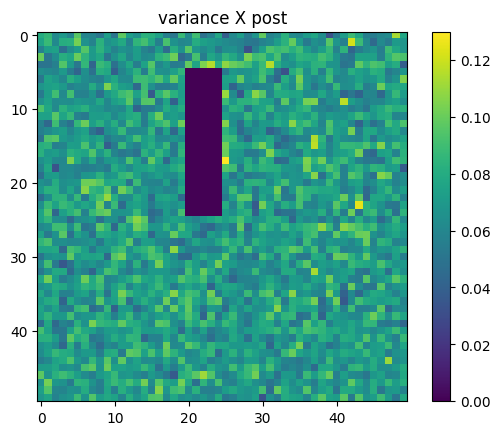

In [28]:
var_x_post_samples = jnp.var(jnp.stack([jnp.where(mask==0,x_post,0) for x_post in x_post_samples], axis=0), axis=0)
plt.imshow(var_x_post_samples.reshape(H, W))
plt.title("variance X post")
plt.colorbar()
plt.show()

### Simple Rao-Blackwellized Monte Carlo

In [29]:
var_x_post_samples_RBMC = model.dgmrf.rbmc_variance(x_post_samples, model.noise_parameter, mask=mask)

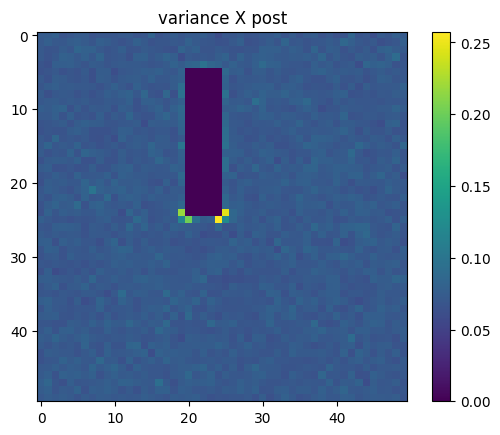

In [30]:
plt.imshow(var_x_post_samples_RBMC.reshape(H, W))
plt.title("variance X post")
plt.colorbar()
plt.show()